In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

seed=42
utils.seed_everything(seed=seed)

subj = 1 #note: we only trained subjects 1 2 5 7, since they have data across full sessions
if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
print("subj",subj,"num_voxels",num_voxels)

device: cuda
subj 1 num_voxels 15724


# Image/Brain retrieval

In [2]:
batch_size = 300 # same as used in mind_reader

data_path = "/fsx/proj-medarc/fmri/natural-scenes-dataset"
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982

val_batch_size = 300
val_loops = 30
voxels_key = 'nsdgeneral.npy' # 1d inputs

val_data = wds.WebDataset(val_url, resampled=True)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(val_batch_size, partial=False)\
    .with_epoch(val_loops)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, coco) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    break

idx 0
voxel.shape torch.Size([300, 3, 15724])
img_input.shape torch.Size([300, 3, 256, 256])


In [3]:
out_dim = 257 * 768
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

out_dim = 768
depth = 6
dim_head = 64
heads = 12 # heads * dim_head = 12 * 64 = 768
timesteps = 100

prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        learned_query_mode="pos_emb"
    ).to(device)

diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
    voxel2clip=voxel2clip,
).to(device)

# model_name = "prior_257_final_subj01_bimixco_softclip_byol_"
# outdir = f'../train_logs/{model_name}'
# ckpt_path = os.path.join(outdir, f'last.pth')

model_name = f'prior_257_final_subj0{subj}_bimixco_softclip_byol'
ckpt_path = f'/fsx/proj-medarc/fmri/fMRI-reconstruction-NSD/train_logs/models/{model_name}/epoch239.pth'

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]
pass

ViT-L/14 cuda
ckpt_path /fsx/proj-medarc/fmri/fMRI-reconstruction-NSD/train_logs/models/prior_257_final_subj01_bimixco_softclip_byol/epoch239.pth
EPOCH:  239


In [4]:
percent_correct_fwd, percent_correct_bwd = None, None

for val_i, (voxel, img, coco) in enumerate(tqdm(val_dl,total=val_loops)):
    with torch.no_grad():
        voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions

        emb = clip_extractor.embed_image(img.to(device)).float() # CLIP-Image
        try:
            _, emb_ = diffusion_prior.voxel2clip(voxel.float())#.view(len(voxel),-1,768) # CLIP-Brain
        except:
            emb_ = diffusion_prior.voxel2clip(voxel.float())
        
        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)
        
        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)
        
        labels = torch.arange(len(emb)).to(device)
        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

        assert len(bwd_sim) == batch_size
        
        if percent_correct_fwd is None:
            cnt=len(fwd_sim)
            percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
            percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
        else:
            cnt+=len(fwd_sim)
            percent_correct_fwd += utils.topk(fwd_sim, labels,k=1)
            percent_correct_bwd += utils.topk(bwd_sim, labels,k=1)
            
        if val_i==0:
            print("Loop 0:",percent_correct_fwd, percent_correct_bwd)
            
print("cnt",cnt,"val_i",val_i)
percent_correct_fwd /= (val_i+1)
percent_correct_bwd /= (val_i+1)
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

fwd_sim = np.array(fwd_sim.cpu())
bwd_sim = np.array(bwd_sim.cpu())

  0%|                                                                                                        | 0/30 [00:00<?, ?it/s]/fsx/home-paulscotti/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  3%|███▏                                                                                            | 1/30 [00:13<0

Loop 0: tensor(0.9733, device='cuda:0') tensor(0.9367, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:18<00:00,  6.60s/it]

cnt 9000 val_i 29
fwd percent_correct tensor(0.9704, device='cuda:0')
bwd percent_correct tensor(0.9458, device='cuda:0')


## Image retrieval visualization

Given Brain embedding, find correct Image embedding


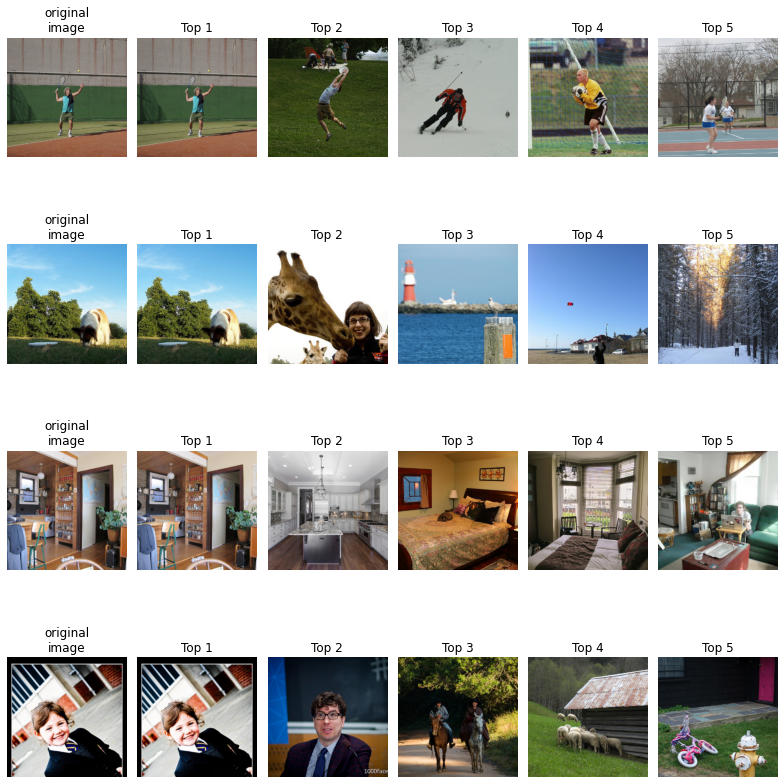

In [12]:
print("Given Brain embedding, find correct Image embedding")
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

### Zebra example

In [30]:
device = 'cpu' # move to cpu to not OOM with all 982 samples
clip_extractor0 = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
diffusion_prior=diffusion_prior.to(device)

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(982, partial=True)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)
for val_i, (voxel, img, coco) in enumerate(tqdm(val_dl,total=1)):
    with torch.no_grad():
        voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions

        emb = clip_extractor0.embed_image(img.to(device)).float() # CLIP-Image
        try:
            _, emb_ = diffusion_prior.voxel2clip(voxel.float())#.view(len(voxel),-1,768) # CLIP-Brain
        except:
            emb_ = diffusion_prior.voxel2clip(voxel.float())
        
        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)
        
        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)
        
        labels = torch.arange(len(emb)).to(device)
        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip
        
        if percent_correct_fwd is None:
            cnt=len(fwd_sim)
            percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
            percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
        else:
            cnt+=len(fwd_sim)
            percent_correct_fwd += utils.topk(fwd_sim, labels,k=1)
            percent_correct_bwd += utils.topk(bwd_sim, labels,k=1)
            
print(percent_correct_fwd, percent_correct_bwd)
fwd_sim = fwd_sim.numpy()
bwd_sim = bwd_sim.numpy()

tensor(0.9318) tensor(0.8778)


# zebras = 2


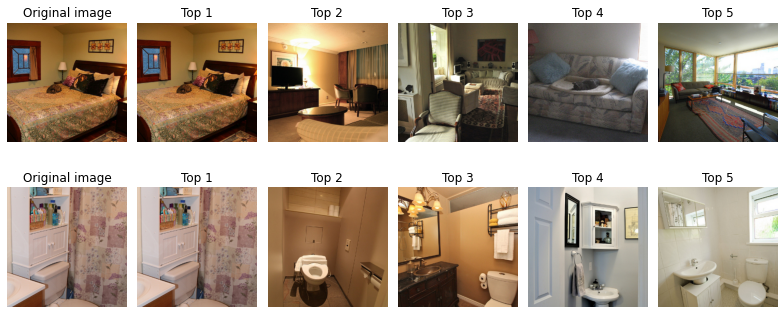

In [58]:
zebra_indices = [32,33]#[891, 892, 893, 863, 833, 652, 516, 512, 498, 451, 331, 192, 129, 66] # 10
print("# zebras =", len(zebra_indices))
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(11,5))
for trial,t in enumerate(zebra_indices[:2]):
    ax[trial, 0].imshow(utils.torch_to_Image(img_input[t]))
    ax[trial, 0].set_title("Original image")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[t]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img_input[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

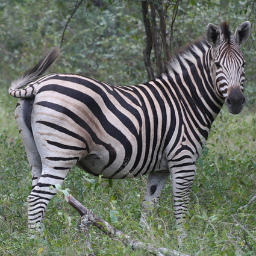

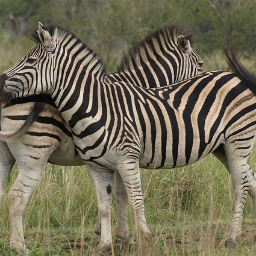

In [46]:
for z in zebra_indices[:2]:
    display(utils.torch_to_Image(img_input[z]))

## Brain retrieval visualization

Given Image embedding, find correct Brain embedding


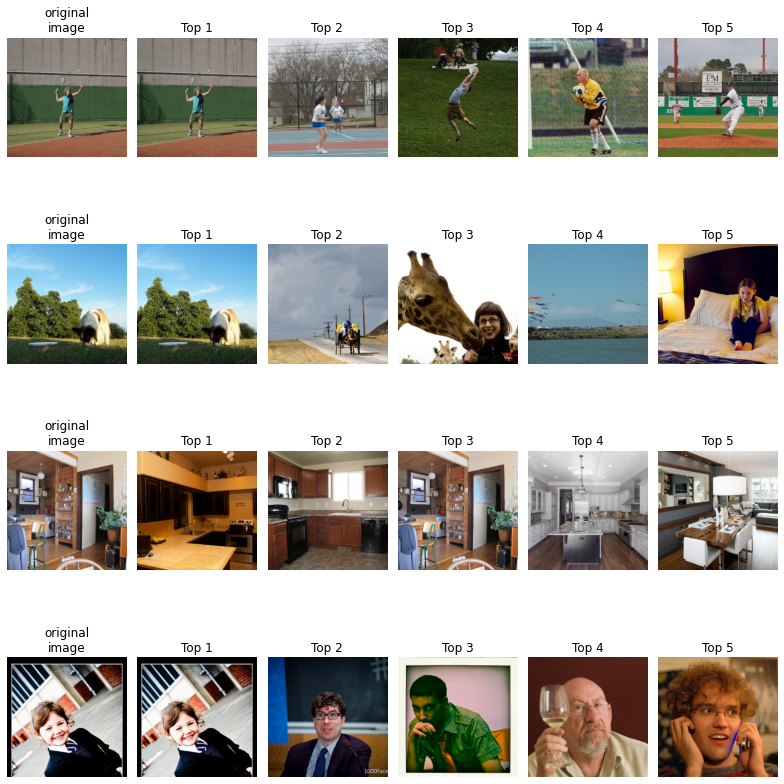

In [13]:
print("Given Image embedding, find correct Brain embedding")
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

# LAION-5B Retrieval

In [72]:
data_path = "/fsx/proj-medarc/fmri/natural-scenes-dataset"
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = val_batch_size = 1
voxels_key = 'nsdgeneral.npy' # 1d inputs

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(val_batch_size, partial=False)

val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, coco) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    break

idx 0
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])


In [73]:
out_dim = 257 * 768
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

out_dim = 768
depth = 6
dim_head = 64
heads = 12 # heads * dim_head = 12 * 64 = 768
timesteps = 100

prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        learned_query_mode="pos_emb"
    ).to(device)

diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
    voxel2clip=voxel2clip,
).to(device)

# model_name = "prior_257_final_subj01_bimixco_softclip_byol_"
# outdir = f'../train_logs/{model_name}'
# ckpt_path = os.path.join(outdir, f'last.pth')

model_name = f'prior_257_final_subj0{subj}_bimixco_softclip_byol'
ckpt_path = f'/fsx/proj-medarc/fmri/fMRI-reconstruction-NSD/train_logs/models/{model_name}/epoch239.pth'

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]
pass

# CLS model
out_dim = 768
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip_cls = BrainNetwork(**voxel2clip_kwargs)
voxel2clip_cls.requires_grad_(False)
voxel2clip_cls.eval()

diffusion_prior_cls = BrainDiffusionPriorOld.from_pretrained(
    # kwargs for DiffusionPriorNetwork
    dict(),
    # kwargs for DiffusionNetwork
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip_cls,
    ),
    voxel2clip_path=None,
)

model_name_cls = "final_subj01_1x768"
outdir = f'../train_logs/{model_name_cls}'
ckpt_path = os.path.join(outdir, f'last.pth')
print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior_cls.load_state_dict(state_dict,strict=False)
diffusion_prior_cls.eval().to(device)
pass

ViT-L/14 cpu


KeyboardInterrupt: 

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

recons_per_sample = 0
retrieve = True
plotting = False
saving = True
verbose = False
imsize = 512

all_brain_recons = None
ind_include = np.arange(num_val)

for val_i, (voxel, img, coco) in enumerate(tqdm(val_dl,total=len(ind_include))):
    if val_i<np.min(ind_include):
        continue
    voxel = torch.mean(voxel,axis=1).to(device)
    # voxel = voxel[:,0].to(device)
    with torch.no_grad():        
        grid, brain_recons, laion_best_picks, recon_img = utils.reconstruction(
            img, voxel,
            clip_extractor,
            voxel2clip_cls = diffusion_prior_cls.voxel2clip,
            diffusion_priors = diffusion_priors,
            text_token = None,
            n_samples_save = batch_size,
            recons_per_sample = recons_per_sample,
            seed = seed,
            retrieve = retrieve,
            plotting = plotting,
            verbose = verbose,
            num_retrieved=10,
        )
            
        if plotting:
            plt.show()
            # grid.savefig(f'evals/{model_name}_{val_i}.png')
            # plt.close()
            
        brain_recons = brain_recons[laion_best_picks.astype(np.int8)]

        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_images = img
        else:
            all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            all_images = torch.vstack((all_images,img))
            
    if val_i>=np.max(ind_include):
        break

all_brain_recons = all_brain_recons.view(-1,3,imsize,imsize)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

if saving:
    # torch.save(all_images,'evals/all_images')
    torch.save(all_brain_recons,f'evals/{model_name}_laion_retrievals')
print(f'evals/{model_name}_laion_retrievals done!')

----

In [20]:
with torch.no_grad():
    _,cls_embeddings=diffusion_prior_cls.voxel2clip(voxel.float())
    
# clip_extractor0 = Clipper("ViT-L/14", hidden_state=False, norm_embs=True, device=device)
# cls_embeddings = clip_extractor0.embed_image(img)

utils.torch_to_Image(utils.query_laion(emb=cls_embeddings.flatten(),groundtruth=None,num=1,
                                   clip_extractor=clip_extractor,device=device,verbose=False))

device(type='cuda', index=0)

In [4]:
# out_dim = 1024
# clip_extractor = OpenClipper("ViT-H-14", norm_embs=False, device=device)
out_dim = 768
clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=False, device=device)
voxel2clip_kwargs = dict(out_dim=out_dim, clip_size=out_dim, use_projector=True)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

diffusion_prior_cls = BrainDiffusionPriorOld.from_pretrained(
    # kwargs for DiffusionPriorNetwork
    dict(),
    # kwargs for DiffusionNetwork
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip,
    ),
    voxel2clip_path=None,
)

model_name = "final_subj01_1x768"
outdir = f'../train_logs/{model_name}'
ckpt_path = os.path.join(outdir, f'last.pth')
print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior_cls.load_state_dict(state_dict,strict=False)
diffusion_prior_cls.eval().to(device)
pass

ViT-L/14 cuda
ckpt_path ../train_logs/final_subj01_1x768/last.pth
EPOCH:  299


In [7]:
percent_correct_fwd, percent_correct_bwd = None, None
clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=True, device=device)
for val_i, (voxel, img, coco) in enumerate(tqdm(val_dl,total=val_loops)):
    with torch.no_grad():
        voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions

        emb = clip_extractor.embed_image(img.to(device)).float() # CLIP-Image
        _, emb_ = diffusion_prior_cls.voxel2clip(voxel.float())#.view(len(voxel),-1,768) # CLIP-Brain
        # except:
        #     emb_ = diffusion_prior.voxel2clip(voxel.float())
        
        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)
        
        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)
        
        labels = torch.arange(len(emb)).to(device)
        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

        assert len(bwd_sim) == batch_size
        
        if percent_correct_fwd is None:
            cnt=len(fwd_sim)
            percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
            percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
        else:
            cnt+=len(fwd_sim)
            percent_correct_fwd += utils.topk(fwd_sim, labels,k=1)
            percent_correct_bwd += utils.topk(bwd_sim, labels,k=1)
            
        if val_i==0:
            print("Loop 0:",percent_correct_fwd, percent_correct_bwd)
            
print("cnt",cnt,"val_i",val_i)
percent_correct_fwd /= (val_i+1)
percent_correct_bwd /= (val_i+1)
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

fwd_sim = np.array(fwd_sim.cpu())
bwd_sim = np.array(bwd_sim.cpu())

ViT-L/14 cuda


  0%|                                                                              | 0/30 [00:00<?, ?it/s]/fsx/home-paulscotti/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  3%|██▎                                                                   | 1/30 [00:06<03:15,  6.75s/it]

Loop 0: tensor(0.6033, device='cuda:0') tensor(0.6033, device='cuda:0')


100%|█████████████████████████████████████████████████████████████████████| 30/30 [01:35<00:00,  3.19s/it]

cnt 9000 val_i 29
fwd percent_correct tensor(0.6178, device='cuda:0')
bwd percent_correct tensor(0.5838, device='cuda:0')
